In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [3]:
import json
import gzip
data = []
with gzip.open('reviews_Clothing_Shoes_and_Jewelry_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [4]:
data[:3]

[{'asin': '0000031887',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': "This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++",
  'reviewTime': '02 12, 2011',
  'reviewerID': 'A1KLRMWW2FWPL4',
  'reviewerName': 'Amazon Customer "cameramom"',
  'summary': 'Great tutu-  not cheaply made',
  'unixReviewTime': 1297468800},
 {'asin': '0000031887',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': 'I bought this for my 4 yr old daughter for dance class, she wore it today for the first time and the teacher thought it was adorable. I bought this to go with a light blue long sleeve leotard and was happy the colors matched up great. Price was very good too since some of these go for over $15.00 dollars.',
  'reviewTime': '01 19, 2013',
  'reviewerID': 'A2G5TCU2WDFZ65',
  'reviewerName': 'Amazon Customer',
  'summary': 'Very Cute!!',
  'unixReviewTime': 1358553600},


In [5]:
df = pd.DataFrame.from_dict(data)

print(len(df))
df

278677


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5.0,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5.0,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5.0,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5.0,Holds Up Well In Real World Test,1404691200,"07 7, 2014"


In [6]:
df = df[['reviewText', 'overall']]
df.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5.0
1,I bought this for my 4 yr old daughter for dan...,5.0
2,What can I say... my daughters have it in oran...,5.0
3,"We bought several tutus at once, and they are ...",5.0
4,Thank you Halo Heaven great product for Little...,5.0


In [7]:
df.describe()

,overall
count,278677.000000
mean,4.245133
std,1.103747
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
df.overall.value_counts()

5.0    163240
4.0     58357
3.0     30425
2.0     15463
1.0     11192
Name: overall, dtype: int64

#### Since the data is left_skewed, we can classify into 2 groups: 5.0 review and not 5.0 (1 to 4).

In [9]:
df['class'] = df['overall'].map(lambda x: 1 if x==5.0 else 0)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewText,overall,class
0,This is a great tutu and at a really great pri...,5.0,1
1,I bought this for my 4 yr old daughter for dan...,5.0,1
2,What can I say... my daughters have it in oran...,5.0,1
3,"We bought several tutus at once, and they are ...",5.0,1
4,Thank you Halo Heaven great product for Little...,5.0,1


In [10]:
df['class'].value_counts()

1    163240
0    115437
Name: class, dtype: int64

In [11]:
df = df[['reviewText', 'class']]
df.head()

,reviewText,class
0,This is a great tutu and at a really great pri...,1
1,I bought this for my 4 yr old daughter for dan...,1
2,What can I say... my daughters have it in oran...,1
3,"We bought several tutus at once, and they are ...",1
4,Thank you Halo Heaven great product for Little...,1


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Label')

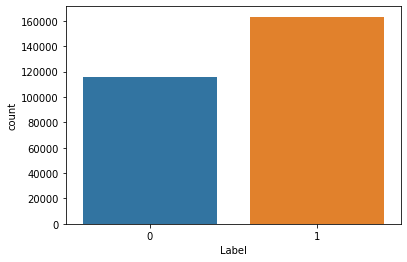

In [13]:
sns.countplot(df['class'])
plt.xlabel('Label')

In [14]:
X = df['reviewText']
Y = df['class']

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [16]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train) 
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [17]:
print(sequences[:2])

[[60, 26, 4, 8, 4, 748, 35, 32, 734, 195, 497, 21, 6, 33, 259], [10, 161, 321, 37, 9, 799, 10, 310, 7, 24, 891, 3, 147, 232, 7, 18, 1, 136, 277, 1, 936, 336, 28, 6, 25, 91, 9, 39, 152, 176, 648, 1, 149, 18, 1, 936, 14, 3, 239, 125, 28, 13, 269, 297, 121, 11, 4, 197, 598, 184, 6, 7, 48, 82, 607, 68, 600]]


In [18]:
sequences_matrix[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  60,  26,   4,   8,   4, 748,  35,  32,
        734, 195, 497,  21,   6,  33, 259],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

In [19]:
def RNN():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 50, input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [20]:
model = Sequential()
model.add(Embedding(max_words, 50))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy',
optimizer=RMSprop(),
metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(sequences_matrix,Y_train, # train
batch_size=128,
epochs=100,
validation_split=0.2,
callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
1220/1220 [==============================] - 174s 141ms/step - loss: 0.4784 - accuracy: 0.7798 - val_loss: 0.5041 - val_accuracy: 0.7795
Epoch 2/100
1220/1220 [==============================] - 169s 139ms/step - loss: 0.4396 - accuracy: 0.8030 - val_loss: 0.4278 - val_accuracy: 0.8119
Epoch 3/100
1220/1220 [==============================] - 172s 141ms/step - loss: 0.4213 - accuracy: 0.8143 - val_loss: 0.4410 - val_accuracy: 0.8098
Epoch 4/100
1220/1220 [==============================] - 173s 142ms/step - loss: 0.4094 - accuracy: 0.8205 - val_loss: 0.4382 - val_accuracy: 0.8116
Epoch 5/100
1220/1220 [==============================] - 172s 141ms/step - loss: 0.4011 - accuracy: 0.8245 - val_loss: 0.4192 - val_accuracy: 0.8114
Epoch 6/100
1220/1220 [==============================] - 170s 139ms/step - loss: 0.3938 - accuracy: 0.8286 - val_loss: 0.4052 - val_accuracy: 0.8210
Epoch 7/100
1220/1220 [==============================] - 173s 142ms/step - loss: 0.3885 - accuracy: 0.8303

In [24]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [25]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2613/2613 [==============================] - 48s 18ms/step - loss: 0.4310 - accuracy: 0.8116


In [26]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.431
 Accuracy: 0.812


#### The accuracy is more than 80%, so we would accept the model.